In [1]:
import kan
import kan.utils as ku
import torch
import torch.nn as nn
import numpy as np
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions
import numpy.random as npr
import qutip as qt
import sympy
import random

In [2]:
N=10; J1=1; J2=0.2
h = j1j2_functions.J1J2_hamiltonian(N, J1, J2)
eigs = h.eigenstates()
gs = eigs[1][0]
gse = eigs[0][0]

In [4]:
threshold = 1e-10
statesf, signsf = utils.get_nonzero_states(N, gs, threshold)
pred_signsf =  [-1 + 2 * (magnetization.count_half_magnetization(i) % 2) for i in statesf]
deviations = utils.find_sign_deviations(statesf, signsf, pred_signsf)
print(len(deviations))

10


In [5]:
input = utils.generate_input_samples(N, statesf)
labels = torch.tensor(signsf, dtype=torch.float64).reshape((-1, 1))
print(input.shape, labels.shape)
dataset = {'train_input': input, 'train_label': labels, 'test_input': input, 'test_label': labels}

torch.Size([252, 10]) torch.Size([252, 1])


In [102]:
model3N = kan.KAN(width = [N, 2, 1, 1, 1]) # this gets to 0 mistakes with no lamb
model3N(dataset['train_input'])
model3N.fix_symbolic(3, 0, 0, 'tanh')
model3N.symbolic_fun[3].affine = nn.Parameter(torch.tensor([[[1, 0, 1, 0]]], dtype=torch.float64), requires_grad=False)
model3N.fix_symbolic(2, 0, 0, 'cos')
model3N.symbolic_fun[2].affine = nn.Parameter(torch.tensor([[[np.pi, 0, 2, 0]]], dtype=torch.float64), requires_grad=False)

checkpoint directory created: ./model
saving model version 0.0
Best value at boundary.
r2 is 0.2486896812915802
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.1
Best value at boundary.
r2 is 0.9950272440910339
saving model version 0.2


In [103]:
model3N.fit(dataset, steps=20, lamb=2.5e-3); # 3e-2 loss is basically perfect for a=2, 2.5e-3 as lamb seems good for a=2

| train_loss: 1.90e-01 | test_loss: 1.90e-01 | reg: 1.65e+01 | : 100%|█| 20/20 [00:11<00:00,  1.78it

saving model version 0.3


In [104]:
pred = model3N(input)
pred_dev = []
for i in range(labels.shape[0]):
    if torch.sgn(pred[i][0])  != torch.sgn(labels[i][0]):
        pred_dev.append(i)
print(len(pred_dev))

0


In [105]:
torch.sqrt(torch.mean((torch.sgn(pred) - labels) ** 2)).item() # also measure of num mistakes

0.0

In [106]:
torch.sqrt(torch.mean((pred - labels) ** 2)).item()

0.1904091628037021

In [107]:
model3N.prune().width

saving model version 0.4


[[10, 0], [2, 0], [1, 0], [1, 0], [1, 0]]

In [108]:
model3N = model3N.prune()

saving model version 0.4


In [109]:
model3N.symbolic_fun[2].affine = nn.Parameter(model3N.symbolic_fun[2].affine.data, requires_grad=False)
model3N.symbolic_fun[3].affine = nn.Parameter(model3N.symbolic_fun[3].affine.data, requires_grad=False)

In [110]:
model3N.fit(dataset, steps=20, lamb=2.5e-3);

| train_loss: 1.80e-01 | test_loss: 1.80e-01 | reg: 1.54e+01 | : 100%|█| 20/20 [00:11<00:00,  1.80it

saving model version 0.5


In [111]:
pred = model3N(input)
pred_dev = []
for i in range(labels.shape[0]):
    if torch.sgn(pred[i][0])  != torch.sgn(labels[i][0]):
        pred_dev.append(i)
print(len(pred_dev))
print(torch.sqrt(torch.mean((torch.sgn(pred) - labels) ** 2)).item()) # also measure of num mistakes

0
0.0


In [112]:
model3N.prune().width

saving model version 0.6


[[10, 0], [2, 0], [1, 0], [1, 0], [1, 0]]

In [113]:
model3N.fit(dataset, steps=20, lamb=2.5e-3);

| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.53e+01 | : 100%|█| 20/20 [00:06<00:00,  3.26it

saving model version 0.6


In [114]:
model3N.prune().width

saving model version 0.7


[[10, 0], [2, 0], [1, 0], [1, 0], [1, 0]]

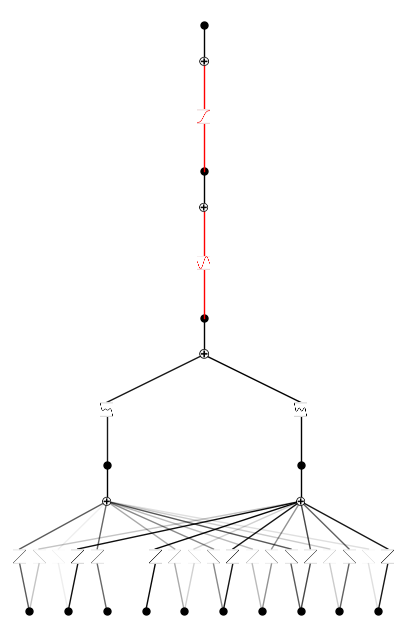

In [115]:
model3N.plot()

    function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        sin    0.542832 -1.129173           2                2   -0.190421
1        cos    0.542832 -1.129173           2                2   -0.190421
2          0    0.000000  0.000014           0                0    0.000010
3        tan    0.477092 -0.935344           3                3    0.245259
4      1/x^2    0.290248 -0.494593           2                2    0.253785
5        exp    0.289534 -0.493142           2                2    0.254801
6          x    0.009552 -0.013832           1                1    0.290318
7        1/x    0.247725 -0.410649           2                2    0.312545
8  1/sqrt(x)    0.240792 -0.397414           2                2    0.321810
9    1/x^0.5    0.240792 -0.397414           2                2    0.321810


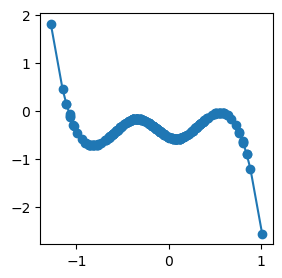

In [116]:
model3N.get_fun(1, 0, 0);
model3N.suggest_symbolic(1, 0, 0, topk=10, weight_simple=0.3);

    function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        cos    0.893703 -3.233686           2                2   -1.663580
1        sin    0.893703 -3.233685           2                2   -1.663579
2          0    0.000000  0.000014           0                0    0.000010
3   gaussian    0.468900 -0.912918           3                3    0.260958
4          x    0.017113 -0.024888           1                1    0.282578
5        1/x    0.100474 -0.152747           2                2    0.493077
6      1/x^2    0.090813 -0.137335           2                2    0.503865
7    1/x^0.5    0.090780 -0.137283           2                2    0.503902
8  1/sqrt(x)    0.090780 -0.137283           2                2    0.503902
9        exp    0.087688 -0.132385           2                2    0.507330


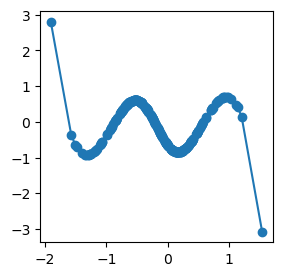

In [117]:
model3N.get_fun(1, 1, 0);
model3N.suggest_symbolic(1, 1, 0, topk=10, weight_simple=0.3);

In [118]:
model3N.fix_symbolic(1, 1, 0, 'cos');

r2 is 0.8937025666236877
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.7


In [119]:
model3N.fit(dataset, steps=20);

| train_loss: 1.70e-01 | test_loss: 1.70e-01 | reg: 1.33e+01 | : 100%|█| 20/20 [00:08<00:00,  2.37it

saving model version 0.8


    function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        sin    0.624904 -1.414631           2                2   -0.390242
1        cos    0.624904 -1.414631           2                2   -0.390242
2          0    0.000000  0.000014           0                0    0.000010
3          x    0.004271 -0.006160           1                1    0.295688
4        exp    0.258763 -0.431973           2                2    0.297619
5      1/x^2    0.257105 -0.428751           2                2    0.299875
6        1/x    0.211966 -0.343652           2                2    0.359444
7  1/sqrt(x)    0.204053 -0.329238           2                2    0.369533
8    1/x^0.5    0.204053 -0.329238           2                2    0.369533
9        tan    0.401442 -0.740412           3                3    0.381711


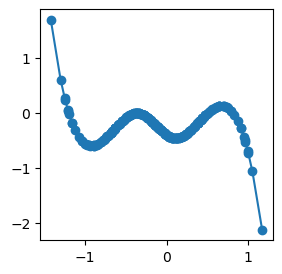

In [120]:
model3N.get_fun(1, 0, 0);
model3N.suggest_symbolic(1, 0, 0, topk=10, weight_simple=0.3);

In [121]:
model3N.fix_symbolic(1, 0, 0, 'cos');

r2 is 0.6249042749404907
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.9


In [122]:
model3N.fit(dataset, steps=20);

| train_loss: 1.50e-01 | test_loss: 1.50e-01 | reg: 1.18e+01 | : 100%|█| 20/20 [00:07<00:00,  2.57it

saving model version 0.10


In [123]:
pred = model3N(input)
pred_dev = []
for i in range(labels.shape[0]):
    if torch.sgn(pred[i][0])  != torch.sgn(labels[i][0]):
        pred_dev.append(i)
print(len(pred_dev))
print(torch.sqrt(torch.mean((torch.sgn(pred) - labels) ** 2)).item()) # also measure of num mistakes

0
0.0


In [126]:
model3N.auto_symbolic(weight_simple=0.3, r2_threshold=0.95);

fixing (0,0,0) with x, r2=1.0000011920928955, c=1
fixing (0,0,1) with x, r2=1.0000007152557373, c=1
fixing (0,1,0) with x, r2=1.0000008344650269, c=1
fixing (0,1,1) with x, r2=1.000001311302185, c=1
fixing (0,2,0) with x, r2=1.0000007152557373, c=1
fixing (0,2,1) with 0
fixing (0,3,0) with x, r2=1.000001072883606, c=1
fixing (0,3,1) with x, r2=1.000001072883606, c=1
fixing (0,4,0) with x, r2=1.0000009536743164, c=1
fixing (0,4,1) with x, r2=1.000001072883606, c=1
fixing (0,5,0) with x, r2=1.000001072883606, c=1
fixing (0,5,1) with x, r2=1.0000011920928955, c=1
fixing (0,6,0) with x, r2=1.0000011920928955, c=1
fixing (0,6,1) with x, r2=1.0000009536743164, c=1
fixing (0,7,0) with x, r2=1.000001072883606, c=1
fixing (0,7,1) with x, r2=1.000001072883606, c=1
fixing (0,8,0) with x, r2=1.000001072883606, c=1
fixing (0,8,1) with x, r2=1.0000009536743164, c=1
fixing (0,9,0) with x, r2=1.000001072883606, c=1
fixing (0,9,1) with x, r2=1.000001311302185, c=1
skipping (1,0,0) since already symboli

In [127]:
model3N.fit(dataset, steps=20);

| train_loss: 1.50e-01 | test_loss: 1.50e-01 | reg: 0.00e+00 | : 100%|█| 20/20 [00:03<00:00,  5.83it

saving model version 0.12


In [128]:
ku.ex_round(utils.symbolic_formula(model3N)[0][0], 4)

1.0*tanh(2.0*cos(3.3475*cos(0.5449*x_1 - 2.2236*x_10 - 2.5789*x_2 - 2.8508*x_4 + 0.7804*x_5 - 1.9904*x_6 + 1.1372*x_7 - 1.0715*x_8 + 1.7516*x_9 + 4.8215) - 2.1697*cos(-2.8262*x_1 + 0.9016*x_10 + 0.6178*x_2 - 3.2304*x_3 + 0.6129*x_4 - 1.8385*x_5 + 1.8922*x_6 - 1.568*x_7 + 2.9788*x_8 - 0.836*x_9 + 0.0772) + 1.5708))

In [204]:
model3N.saveckpt('model_files/symb_fix_tanh_cos_10_2_1_1_1')

In [403]:
first_cos_coef = [0.545, -2.579, 0, -2.85, 0.78, -1.99, 1.13, -1.07, 1.75, -2.22]
second_cos_coef = [-2.826, 0.618, -3.23, 0.613, -1.835, 1.89, -1.568, 2.98, -0.836, 0.901]
def manual_fun(x):
    return torch.tanh(2 * torch.cos(3.34 * torch.cos(sum(first_cos_coef[i] * x[:, i] for i in range(N)) + 4.82) - 2.1697 * torch.cos(sum(second_cos_coef[i] * x[:, i] for i in range(N)) + 0.0772) + 1.57))
def modified_fun(x):
    return torch.tanh(-2 * torch.sin(3.34 * torch.cos(sum(first_cos_coef[i] * x[:, i] for i in range(N)) + 4.82) - 2.1697 * torch.cos(sum(second_cos_coef[i] * x[:, i] for i in range(N)) )))

In [404]:
#torch.abs(model3N(input).reshape(-1) - manual_fun(input)) this is good

In [ ]:
print('loss', torch.sqrt(torch.mean((model3N(input) - labels) ** 2)).item() )
print('snap loss', torch.sqrt(torch.mean((torch.sgn(model3N(input)) - labels) ** 2)).item()) # also measure of num mistakes
print('mod loss', torch.sqrt(torch.mean((modified_fun(input).reshape(-1, 1) - labels) ** 2)).item())
print('snap mod loss', torch.sqrt(torch.mean((torch.sgn(modified_fun(input).reshape(-1, 1)) - labels) ** 2)).item())

loss 0.15028478521691885
snap loss 0.0
mod loss 0.1677474122748549
snap mod loss 0.0


: 

In [205]:
np.array(first_cos_coef) + np.array(second_cos_coef)

array([-2.281, -1.961, -3.23 , -2.237, -1.055, -0.1  , -0.438,  1.91 ,
        0.914, -1.319])

In [206]:
np.array(first_cos_coef) - np.array(second_cos_coef) # seem sorta close to pi??  

array([ 3.371, -3.197,  3.23 , -3.463,  2.615, -3.88 ,  2.698, -4.05 ,
        2.586, -3.121])

In [141]:
utils.symbolic_formula(model3N)

([1.0*tanh(2.0*cos(3.34752320774396*cos(0.544946154345259*x_1 - 2.22363982848632*x_10 - 2.57894603938833*x_2 - 2.85082151973769*x_4 + 0.780351054686128*x_5 - 1.99039603359671*x_6 + 1.13720661684774*x_7 - 1.07154768278272*x_8 + 1.75159171375662*x_9 + 4.82145813485576) - 2.16971433305957*cos(-2.82620226455693*x_1 + 0.901648907958341*x_10 + 0.617798712982068*x_2 - 3.23043915004537*x_3 + 0.612881241080531*x_4 - 1.83849518684647*x_5 + 1.8922294571148*x_6 - 1.56799065389684*x_7 + 2.97882079952936*x_8 - 0.836047390712836*x_9 + 0.07715229483621) + 1.57079890153072))],
 [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10])

In [145]:
sympy.print_latex(ku.ex_round(utils.symbolic_formula(model3N)[0][0], 4))

1.0 \tanh{\left(2.0 \cos{\left(3.3475 \cos{\left(0.5449 x_{1} - 2.2236 x_{10} - 2.5789 x_{2} - 2.8508 x_{4} + 0.7804 x_{5} - 1.9904 x_{6} + 1.1372 x_{7} - 1.0715 x_{8} + 1.7516 x_{9} + 4.8215 \right)} - 2.1697 \cos{\left(- 2.8262 x_{1} + 0.9016 x_{10} + 0.6178 x_{2} - 3.2304 x_{3} + 0.6129 x_{4} - 1.8385 x_{5} + 1.8922 x_{6} - 1.568 x_{7} + 2.9788 x_{8} - 0.836 x_{9} + 0.0772 \right)} + 1.5708 \right)} \right)}


In [138]:
utils.symbolic_formula(model3N)[0][0].evalf(2, {'x_1': 1})

1.0*tanh(2.0*cos(3.34752320774396*cos(2.22363982848632*x_10 + 2.57894603938833*x_2 + 2.85082151973769*x_4 - 0.780351054686128*x_5 + 1.99039603359671*x_6 - 1.13720661684774*x_7 + 1.07154768278272*x_8 - 1.75159171375662*x_9 - 5.36640428920102) - 2.16971433305957*cos(0.901648907958341*x_10 + 0.617798712982068*x_2 - 3.23043915004537*x_3 + 0.612881241080531*x_4 - 1.83849518684647*x_5 + 1.8922294571148*x_6 - 1.56799065389684*x_7 + 2.97882079952936*x_8 - 0.836047390712836*x_9 - 2.74904996972072) + 1.57079890153072))

In [337]:
model_fix = kan.KAN(width = [N, 2, 1, 1, 1]) # this gets to 0 mistakes with no lamb
model_fix(dataset['train_input'])
model_fix.fix_symbolic(3, 0, 0, 'tanh')
model_fix.symbolic_fun[3].affine = nn.Parameter(torch.tensor([[[1, 0, 1, 0]]], dtype=torch.float64), requires_grad=False)
model_fix.fix_symbolic(2, 0, 0, 'cos')
model_fix.symbolic_fun[2].affine = nn.Parameter(torch.tensor([[[np.pi, 0, 2, 0]]], dtype=torch.float64), requires_grad=False)

checkpoint directory created: ./model
saving model version 0.0
Best value at boundary.
r2 is 0.24868926405906677
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.1
Best value at boundary.
r2 is 0.9950270652770996
saving model version 0.2


In [338]:
model_fix.fit(dataset, steps=20);

| train_loss: 1.87e-01 | test_loss: 1.87e-01 | reg: 1.59e+01 | : 100%|█| 20/20 [00:10<00:00,  1.91it

saving model version 0.3


In [339]:
torch.sqrt(torch.mean((torch.sgn(model_fix(input)) - labels) ** 2))

tensor(0., dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [340]:
model_fix.prune().width

saving model version 0.4


[[10, 0], [2, 0], [1, 0], [1, 0], [1, 0]]

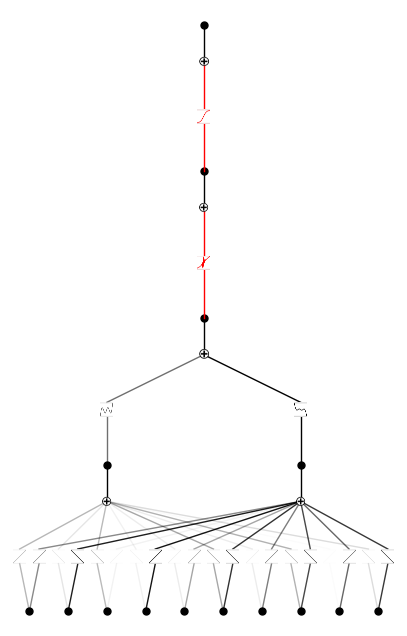

In [341]:
model_fix.plot()

   function  fitting r2   r2 loss  complexity  complexity loss  total loss
0       sin    0.941197 -4.087721           2                2   -2.261404
1       cos    0.941197 -4.087719           2                2   -2.261403
2         0    0.000000  0.000014           0                0    0.000010
3  gaussian    0.515699 -1.045995           3                3    0.167804
4         x    0.017969 -0.026145           1                1    0.281698


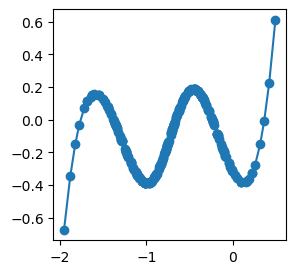

In [342]:
model_fix.get_fun(1, 0, 0);
model_fix.suggest_symbolic(1, 0, 0, weight_simple=0.3);

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0      cos    0.470027 -0.915982           2                2   -0.041187
1      sin    0.470027 -0.915982           2                2   -0.041187
2        0    0.000000  0.000014           0                0    0.000010
3      x^5    0.565743 -1.203347           3                3    0.057657
4      tan    0.550895 -1.154843           3                3    0.091610


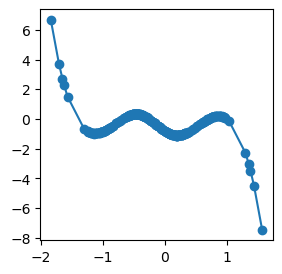

In [343]:
model_fix.get_fun(1, 1, 0);
model_fix.suggest_symbolic(1, 1, 0, weight_simple=0.3);

In [344]:
model_fix.fix_symbolic(1, 0, 0, 'cos')
# model_fix.fix_symbolic(1, 0, 0, 'cos')
# model_fix.symbolic_fun[1].affine = nn.Parameter(torch.tensor([[[np.pi, 0, 1, 0], [np.pi, 0, 1, 0]]], dtype=torch.float64), requires_grad=False)

r2 is 0.9411969184875488
saving model version 0.4


tensor(0.9412)

In [345]:
model_fix.fit(dataset, steps=20);

| train_loss: 1.89e-01 | test_loss: 1.89e-01 | reg: 1.41e+01 | : 100%|█| 20/20 [00:06<00:00,  3.16it

saving model version 0.5


  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0      sin    0.484371 -0.955566           2                2   -0.068896
1      cos    0.484371 -0.955566           2                2   -0.068896
2        0    0.000000  0.000014           0                0    0.000010
3      x^5    0.559069 -1.181342           3                3    0.073061
4        x    0.118830 -0.182492           1                1    0.172256


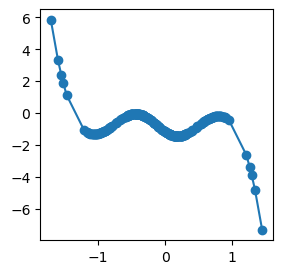

In [346]:
model_fix.get_fun(1, 1, 0);
model_fix.suggest_symbolic(1, 1, 0, weight_simple=0.3);

In [347]:
model_fix.fix_symbolic(1, 1, 0, 'cos');

r2 is 0.48437079787254333
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.6


In [348]:
model_fix.fit(dataset, steps=20);

| train_loss: 1.50e-01 | test_loss: 1.50e-01 | reg: 1.17e+01 | : 100%|█| 20/20 [00:07<00:00,  2.63it

saving model version 0.7


In [349]:
torch.sqrt(torch.mean((torch.sgn(model_fix(input)) - labels) ** 2))

tensor(0., dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [350]:
pred = model_fix(input)
pred_dev = []
for i in range(labels.shape[0]):
    if torch.sgn(pred[i][0])  != torch.sgn(labels[i][0]):
        pred_dev.append(i)
print(len(pred_dev))
print(torch.sqrt(torch.mean((torch.sgn(pred) - labels) ** 2)).item()) # also measure of num mistakes

0
0.0


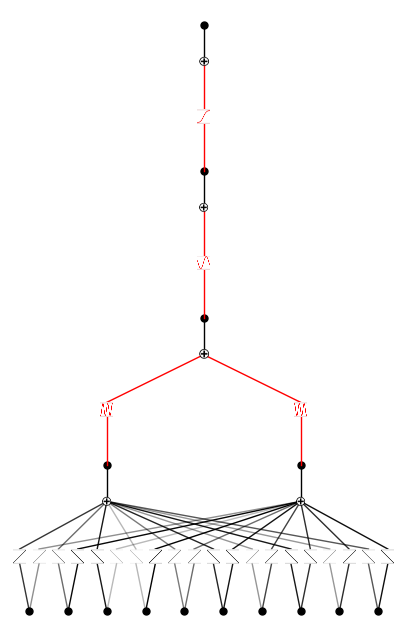

In [351]:
model_fix.plot()

In [352]:
model_fix.auto_symbolic(weight_simple=0.3);

fixing (0,0,0) with x, r2=1.0000009536743164, c=1
fixing (0,0,1) with x, r2=1.0000011920928955, c=1
fixing (0,1,0) with x, r2=1.000001072883606, c=1
fixing (0,1,1) with x, r2=1.0000009536743164, c=1
fixing (0,2,0) with x, r2=1.000001072883606, c=1
fixing (0,2,1) with x, r2=1.0000009536743164, c=1
fixing (0,3,0) with x, r2=1.0000009536743164, c=1
fixing (0,3,1) with x, r2=1.0000011920928955, c=1
fixing (0,4,0) with x, r2=1.0000009536743164, c=1
fixing (0,4,1) with x, r2=1.0000009536743164, c=1
fixing (0,5,0) with x, r2=1.0000011920928955, c=1
fixing (0,5,1) with x, r2=1.000001072883606, c=1
fixing (0,6,0) with x, r2=1.0000011920928955, c=1
fixing (0,6,1) with x, r2=1.000001311302185, c=1
fixing (0,7,0) with x, r2=1.0000009536743164, c=1
fixing (0,7,1) with x, r2=1.0000011920928955, c=1
fixing (0,8,0) with x, r2=1.0000007152557373, c=1
fixing (0,8,1) with x, r2=1.0000008344650269, c=1
fixing (0,9,0) with x, r2=1.0000011920928955, c=1
fixing (0,9,1) with x, r2=1.0000009536743164, c=1
skip

In [353]:
model_fix.fit(dataset, steps=20);

| train_loss: 1.50e-01 | test_loss: 1.50e-01 | reg: 0.00e+00 | : 100%|█| 20/20 [00:02<00:00,  7.10it

saving model version 0.9


In [354]:
ku.ex_round(utils.symbolic_formula(model_fix)[0][0], 4)

1.0*tanh(2.0*cos(2.1422*cos(-2.149*x_1 + 1.5825*x_10 + 1.3128*x_2 + 3.0465*x_3 + 0.5814*x_4 - 1.1532*x_5 + 2.5751*x_6 - 0.8703*x_7 + 2.9791*x_8 - 0.8656*x_9 - 5.0904) + 3.3211*cos(-0.5728*x_1 + 2.1993*x_10 + 2.5565*x_2 + 0.3455*x_3 - 3.1138*x_4 - 0.8025*x_5 + 1.9676*x_6 - 1.1579*x_7 + 1.4219*x_8 - 1.4323*x_9 + 7.1482) + 1.5708))

In [360]:
dir(utils.symbolic_formula(model_fix)[0][0])

['__abs__',
 '__add__',
 '__annotations__',
 '__class__',
 '__complex__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getnewargs__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__le__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__round__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__sympy__',
 '__truediv__',
 '__trunc__',
 '_add_handler',
 '_args',
 '_args_type',
 '_assumptions',
 '_combine_inverse',
 '_compare_pretty',
 '_constructor_postprocessor_mapping',
 '_diff_wrt',
 '_do_eq_sympify',
 '_eval_adjoint',
 '_eval_as_leading_term',
 '_eval_conj

In [262]:
model_fix.symbolic_fun[1].affine

Parameter containing:
tensor([[[3.1416, 0.0000, 1.0000, 0.0000],
         [3.1416, 0.0000, 1.0000, 0.0000]]], dtype=torch.float64)

In [246]:
# c*f(a*x+b)+d
model_fix.symbolic_fun[1].affine = nn.Parameter(model_fix.symbolic_fun[1].affine.detach(), requires_grad=False)
model_fix.symbolic_fun[1].affine[0][0][0] = np.pi
model_fix.symbolic_fun[1].affine[0][1][0] = np.pi
model_fix.symbolic_fun[1].affine[0][0][2] = 1
model_fix.symbolic_fun[1].affine[0][1][2] = 1
model_fix.symbolic_fun[1].affine

Parameter containing:
tensor([[[ 3.1416,  3.9297,  1.0000, -0.0881],
         [ 3.1416,  3.9913,  1.0000, -0.4119]]])

In [247]:
model_fix.symbolic_fun[1].affine = nn.Parameter(model_fix.symbolic_fun[1].affine, requires_grad=True)

In [249]:
model_fix.symbolic_fun[1].affine

Parameter containing:
tensor([[[ 3.0930,  3.8829,  0.8825, -0.0531],
         [ 3.1641,  3.9658,  1.1450, -0.3768]]], requires_grad=True)

In [248]:
model_fix.fit(dataset, steps=20);

| train_loss: 3.46e-01 | test_loss: 3.46e-01 | reg: 1.15e+01 | : 100%|█| 20/20 [00:05<00:00,  3.78it

saving model version 0.7
